# Distributions

This notebook presents various well-defined numeric probability distributions that frequently arise in statistical analysis.

I have written it to make it easy for you to see different distributions and different parameters.  Please play with different values to see what happens!

This notebook also demonstrates how to do some plotting with raw matplotlib.

## Math Refresh

A *discrete* probability distribution is a distribution over discrete values.  These may categorical, ordinal, or numeric.  Such a distribution is defined by the **probability mass function** $P(x)$ (for a discrete random variable, $P(X = x)$.

A *continuous* probability distribution is similarly a distribution over continuous values.  Because $P(X = x) = 0$ for a continuous random variable $X$, we instead assign probability mass to intervals.  This is done through the **distribution function** (or cumulative distribution function, or CDF):

$$F(x) = P(X \le x)$$

Such distributions are often defined in terms of a **probability density function** $p(x)$ such that:

$$\begin{align*}
F(x) & = \int_{-\infty}^x p(x) dx \\
p(x) & = \frac{d}{dx} F(x)
\end{align*}$$

The *expected value* of a random variable is:

$$\mathrm{E}[X] = \int x p(x) dx$$

For a discrete variable, replace the integral with a sum and the density with the mass:

$$\mathrm{E}[X] = \sum_x x P(x)$$

Mathematically, we denote that a variable follows a distribution with $\sim$.  To write that $X$ is normally distributed with mean 0 and standard deviation 1, we write:

$$X \sim \mathrm{Normal}(0, 1)$$

Probability functions often take *parameters* that govern their behavior.  The number, range, and interpretation of parameters varies greatly from function to function.

## Setup

Let's load our Python modules:

In [1]:
import numpy as np
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt

### Functions

This notebook is going to be much easier to use (and write) if we define some helper functions.

SciPy provides classes that implement [many distributions](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) in a compatible interface. We're going to use those.

#### Density

Our first function is going to take a distribution and plot its density.  It takes an optional min and max for the $x$ axis, and will use a helper function (defined in a moment) to compute default values if they aren't specified.  But the plot function looks like this:

In [2]:
def plot_density(dist, xmin=None, xmax=None, npts=1000, mass=0.9999):
    xmin, xmax = find_range(dist, xmin, xmax, mass=mass)
    # set up x values
    xs = np.linspace(xmin, xmax, npts)
    # find corresponding densities
    ys = dist.pdf(xs)
    # let's start by plotting the mean & median - we plot this first so the density is on top
    plt.axvline(dist.median(), linestyle=':', alpha=0.5, label='median')
    plt.axvline(dist.mean(), linestyle='--', alpha=0.5, label='mean')
    # and plot the density itself
    plt.plot(xs, ys)
    # and a legend & labels
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Probability Density')

And plot multiple densities at the same time:

In [3]:
def plot_densities(*dists, xmin=None, xmax=None, npts=1000, mass=0.9999):
    ranges = [find_range(d, xmin, xmax, mass) for (l, d) in dists]
    xmin = min(r[0] for r in ranges)
    xmax = max(r[1] for r in ranges)
    # set up x values
    xs = np.linspace(xmin, xmax, npts)
    # plot y values
    for lbl, dist in dists:
        # find corresponding densities
        ys = dist.pdf(xs)
        plt.plot(xs, ys, label=lbl)
    
    # and a legend & labels
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Probability Density')

#### Distribution

We also want to be able to plot CDFs:

In [4]:
def plot_cdf(dist, xmin=None, xmax=None, npts=1000, mass=0.9999):
    xmin, xmax = find_range(dist, xmin, xmax, mass=mass)
    # set up x values
    xs = np.linspace(xmin, xmax, npts)
    # find corresponding densities
    ys = dist.cdf(xs)
    # let's start by plotting the mean & median - we plot this first so the density is on top
    plt.axvline(dist.median(), linestyle=':', alpha=0.5, label='median')
    plt.axvline(dist.mean(), linestyle='--', alpha=0.5, label='mean')
    # and plot the density itself
    plt.plot(xs, ys)
    # and a legend & labels
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Cumulative Probability')

#### Density and CDF

Let's also build a way to plot both the density and the CDF at the same time.

In [30]:
def plot_pdf_cdf(dist, xmin=None, xmax=None, npts=1000, mass=0.9999):
    xmin, xmax = find_range(dist, xmin, xmax, mass=mass)
    # set up x values
    xs = np.linspace(xmin, xmax, npts)
    
    # set up 2 plots
    fig, axs = plt.subplots(2, sharex=True, figsize=(6,8))
    pdf, cdf = axs  # extract two axes
    
    # let's start by plotting the mean & median - we plot this first so the density is on top
    pdf.axvline(dist.median(), linestyle=':', alpha=0.5, label='median')
    cdf.axvline(dist.median(), linestyle=':', alpha=0.5, label='median')
    pdf.axvline(dist.mean(), linestyle='--', alpha=0.5, label='mean')
    cdf.axvline(dist.mean(), linestyle='--', alpha=0.5, label='mean')
    # and plot the density itself
    pdf.plot(xs, dist.pdf(xs))
    # and the CDF
    cdf.plot(xs, dist.cdf(xs))
    # and a legend & labels
    pdf.legend()
    pdf.set_ylabel('Probability Density')
    cdf.set_xlabel('x')
    cdf.set_ylabel('Cumulative Probability')

#### Continuous Range

Now let's define that `find_range` function.  If we already have `xmin` and/or `xmax`, they are left as-is, so we can manually specify the range.  But if they are not, we will use the *inverse CDF* (which SciPy calls the *percent point function* `ppf`) to find values such that the specified probability mass will be between `xmin` and `xmax`.

**Note:** in this function, we reassign the parameter variables.  Python is call-by-value, so this does *not* change the underlying values; it simply reassigns our local variables.

**Note 2:** if we passed a list as a parameter, and modified the list, it would change it for the caller.  This is not a violation of call-by-value; rather, it reflects that object *references* are passed by *value*.  If we modify a list, it is changed because there's just one list object shared between caller and callee; if we assign the variable to contain a reference to a new list, the caller doesn't get to see that, because while it has the *list object*, it doesn't know anything about the variable in which the function stores a refernce to it. Just something to be careful of.

Anyway, here's the function:

In [6]:
def find_range(dist, xmin, xmax, mass=0.999):
    half_excluded_mass = (1 - mass) / 2
    if xmin is None:
        xmin = dist.ppf(half_excluded_mass)
    if xmax is None:
        xmax = dist.ppf(1 - half_excluded_mass)
    return xmin, xmax

#### Mass

Finally, let's plot probability mass for discrete distributions:

In [7]:
def plot_mass(dist, xmin=0, xmax=None, mass=0.9999):
    if xmax is None:
        xmax = dist.ppf(mass + (1 - mass) * 0.5)
    # set up x values
    xs = np.arange(0, xmax + 1)
    # find corresponding densities
    ys = dist.pmf(xs)
    # let's start by plotting the mean & median - we plot this first so the density is on top
    plt.axvline(dist.median(), linestyle=':', alpha=0.5, label='median')
    plt.axvline(dist.mean(), linestyle='--', alpha=0.5, label='mean')
    # and plot the density itself
    plt.bar(xs, ys, width=0.5)
    # and a legend & labels
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Probability')

## Bernoulli Distribution

We'll start with a very simple discrete probability distribution: the *Bernoulli distribution*.

The binomial distribution is a distribution over two outcomes, such as a coin flip.  Conventionally, one outcome is called 'success' and the other 'failure', because it is used to describe the outcome of a *Bernoulli trial*, which is an action or even tthat can either succeed or fail.

This distribution has a single parameter, $\theta$, that is the probability of success:

$$\begin{align*}
P(\mathrm{S}) & = \theta \\
P(\mathrm{F}) & = 1 - \theta
\end{align*}$$

We often encode success and failure numerically as 1 and 0, respectively.

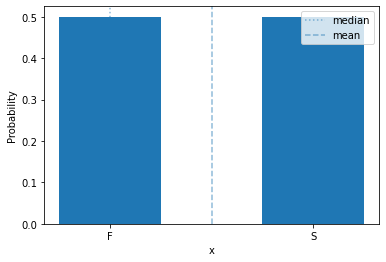

In [8]:
plot_mass(sps.bernoulli(0.5), 0, 1)
plt.xticks([0,1], ['F', 'S'])  # drop excess tick labels & label success & failure
plt.show()

## Binomial Distribution

The *binomial distribution* is a discrete distribution that describes the number of successes ($y$) in a fixed number of Bernoulli trials.  It has two parameters: $\theta \in [0,1]$ is the success probability, and $n$ is the number of trials.
Its probability mass function is:

$$P(Y = y | \theta, n) = \binom{n}{y} \theta^y (1-\theta)^{(n-y)}$$

The probability mass is distributed like this:

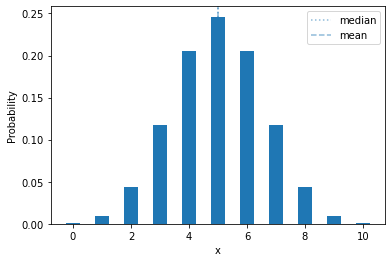

In [9]:
plot_mass(sps.binom(10, 0.5), 0, 10)
plt.show()

One thing we can immediately note: a fair coin ($\theta = 0.5$), flipped 10 times, will have exactly 5 heads **less than 25% of the time!**

If we change the success probability, it shifts left or right:

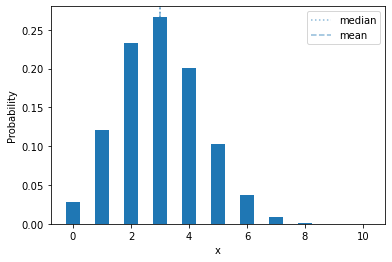

In [10]:
plot_mass(sps.binom(10, 0.3), 0, 10)
plt.show()

Let's show a more extreme example:

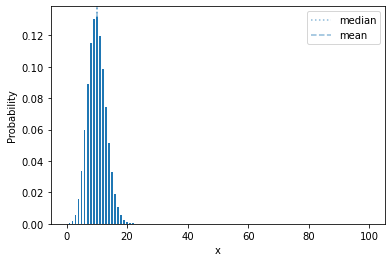

In [11]:
plot_mass(sps.binom(100, 0.1), 0, 100)
plt.show()

## Poisson distribution

The *Poisson* distribution frequently shows up when modeling counts.  The Poisson has a single parameter, the *rate* $\lambda > 0$, that is the mean (expected value) of the distribution.  In terms of a random process, if there is an event that occurs on average $\lambda$ times in a fixed time window, then the number of observed occurrances in such a time window is Poisson-distributed.

It is defined by:

$$P(X = n | \lambda) = \frac{\lambda^n e^{-\lambda}}{n!}$$

Let's look at one:

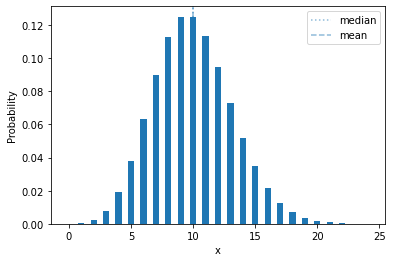

In [12]:
plot_mass(sps.poisson(10))

## Negative Binomial 

The *negative binomial* distribution is another distribution that often shows up in counts.  It plays a similar role as the Poisson, but has two parameters so that two negative binomials can have the same mean but different variances.

The parameters are $r > 0$ and $p \in [0,1]$, and it looks like this:

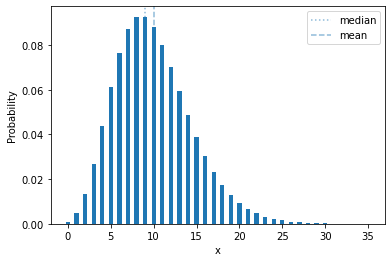

In [13]:
plot_mass(sps.nbinom(10, 0.5))

In terms of a random process, it's the number of failures you will see if you run a Bernoilli trial with probability $p$ until you see $r$ successes.  In the distribution shown above, with $p=0.5$, it's the number of of tails you will see if you flip a coin until you get 10 heads.

## Uniform Distribution

The *uniform* distribution distributes its probability mass equally across a range.  For a discrete variable, every value has equal mass; for a continuous variable, the entire range has equal density.

In order to be defined, it requires both upper and lower limits to the variable.

Here's a continuous uniform density over $[0,10]$:

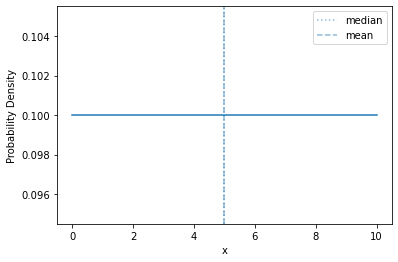

In [14]:
plot_density(sps.uniform(0, 10))

And the CDF:

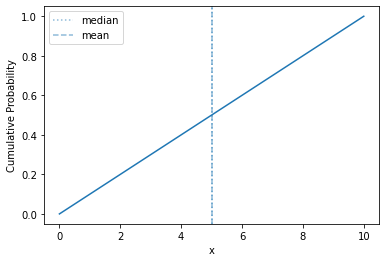

In [15]:
plot_cdf(sps.uniform(0, 10))

Straight line! About as simple as it gets.

## Normal Distribution

A very common continuous distribution is the *normal distribution*, also known as the *Gaussian distribution* and the *bell curve*.  It has two parameters, the mean $\mu$ and standard deviation $\sigma$.

The density of the *standard normal* ($\mu=0$, $\sigma=1$) looks like this:

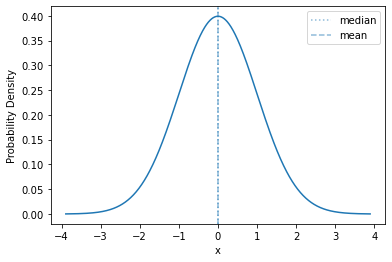

In [16]:
std_norm = sps.norm()
plot_density(std_norm, mass=0.9999)

And its distribution function:

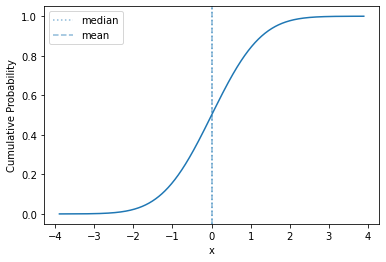

In [17]:
plot_cdf(std_norm, mass=0.9999)

The normal distribution is a *location-scale* distribution.  Such a distribution has *location* and *scale* parameters ($\mu$ is the location and $\sigma$ is the scale), and the distribution can be adjusted through adding the location and multiplying by the scale.

If $X \sim \mathrm{Normal}(0, 1)$, and $Y \sim \mathrm{Normal}(-3, 5)$, then we can simulate $y$ by drawing $x$ and computing $y = 5 - 3 x$.

Let's see the density of $Y$:

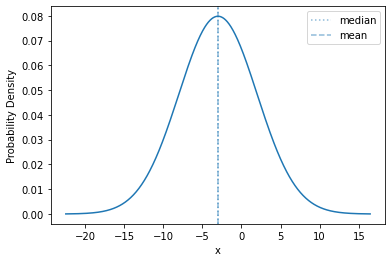

In [18]:
plot_density(sps.norm(-3, 5), mass=0.9999)

The shape is exactly the same; we have just shifted the mean (to -3) and expanded the range of values (from a standard deviation of 1 to 5).  This is what happens with any scale-location distribution!

The normal distribution is *unbounded* ($p_{\mathrm{Normal}}$ is defined over the entire real line).

Let's show off our combined plot, so I can put it in the slide:

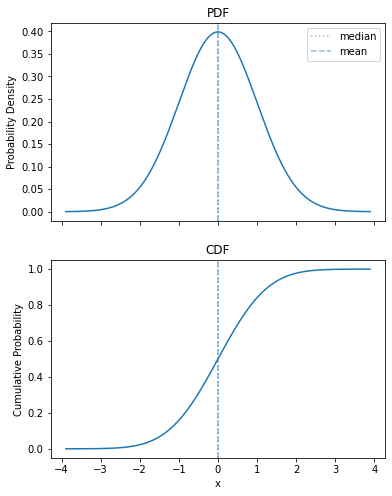

In [29]:
plot_pdf_cdf(sps.norm())

## Exponential Distribution

Another common continuous distribution is the *exponential*.  It is a strongly right-skewed distribution over non-negative numbers defined by a *rate* parameter $\lambda > 0$.  Its density is:

$$p(x | \lambda) = \lambda e^{-\lambda x}$$

Here's what its density looks like:

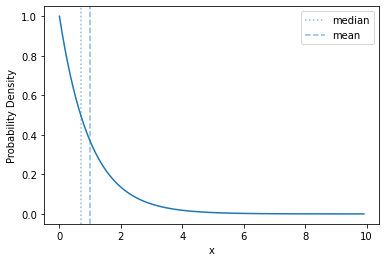

In [18]:
plot_density(sps.expon(scale=1))

The basic shape of of the exponential distribution does not change as you change the rate - it just rescales the range over which the curve is distributed, and the $y$ values

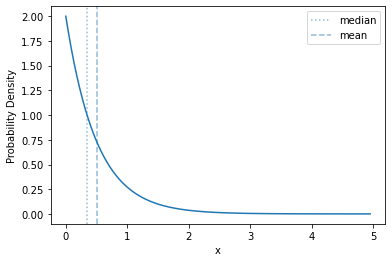

In [19]:
plot_density(sps.expon(scale=0.5))

Let's compare them, directly, though:

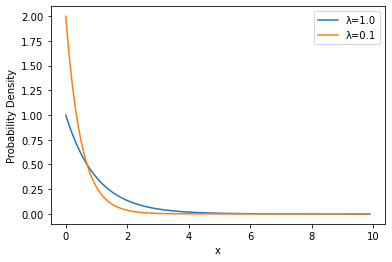

In [20]:
plot_densities(('λ=1.0', sps.expon(scale=1.0)), ('λ=0.1', sps.expon(scale=0.5)))

## Wrapup

There are many probability distributions that cover a variety of different processes and models. I have only touched on a few of them here.